# MVA Mini Project 1

Student: Pierre-Louis Guhur - pierre-louis.guhur@ens-paris-saclay.fr

# 1. Getting started

In [42]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
#from shutil import copyfile
#copyfile(src="../input/mp1.py", dst = "../working/mp1.py")
from mp1 import *

import keras
from keras import optimizers
from keras.layers import Dense
from keras.models import Sequential, clone_model
from keras.utils import np_utils, to_categorical
from keras.callbacks import EarlyStopping

from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D,Activation, UpSampling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.regularizers import l2, l1

from keras_tqdm import TQDMCallback, TQDMNotebookCallback

from tensorflow.test import is_gpu_available
print("GPU is available" if is_gpu_available() else "GPU is not available")

models = {}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GPU is available


# 2. Simple Classification

Example of the classes to classify

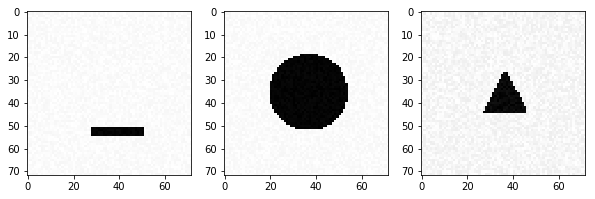

In [81]:
plt.figure(figsize=(10,10))

plt.subplot(131)
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(72,72), cmap='gray')

plt.subplot(132)
im = generate_a_disk(10)
plt.imshow(im.reshape(72,72), cmap='gray')

plt.subplot(133)
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(72,72), cmap='gray')

plt.show()

n_classes = 3
n_hidden = 64

In [91]:
X_train, Y_train = generate_dataset_classification(300, 20, False)
Y_train_cat = to_categorical(Y_train)
X_test, Y_test = generate_test_set_classification(300, 20, False)
Y_test_cat = to_categorical(Y_test)

Creating data: 100%|██████████| 300/300 [00:03<00:00, 89.11it/s] 


## 2.1 Training a model with SGD

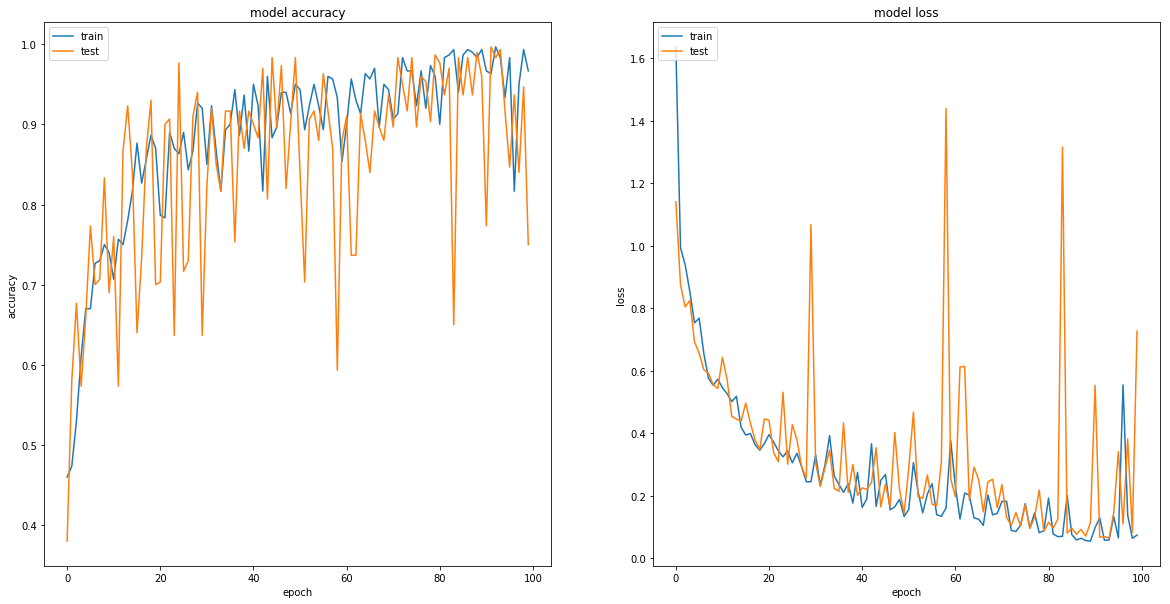

In [112]:
models['sgd'] = Sequential()
models['sgd'].add(Dense(n_hidden, activation='relu', input_shape=(X_train.shape[1],)))
models['sgd'].add(Dense(n_classes, activation='softmax'))
models['sgd'].compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = models['sgd'].fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), verbose=0)
plot_history(history)

## 2.2 Training a model with Adam

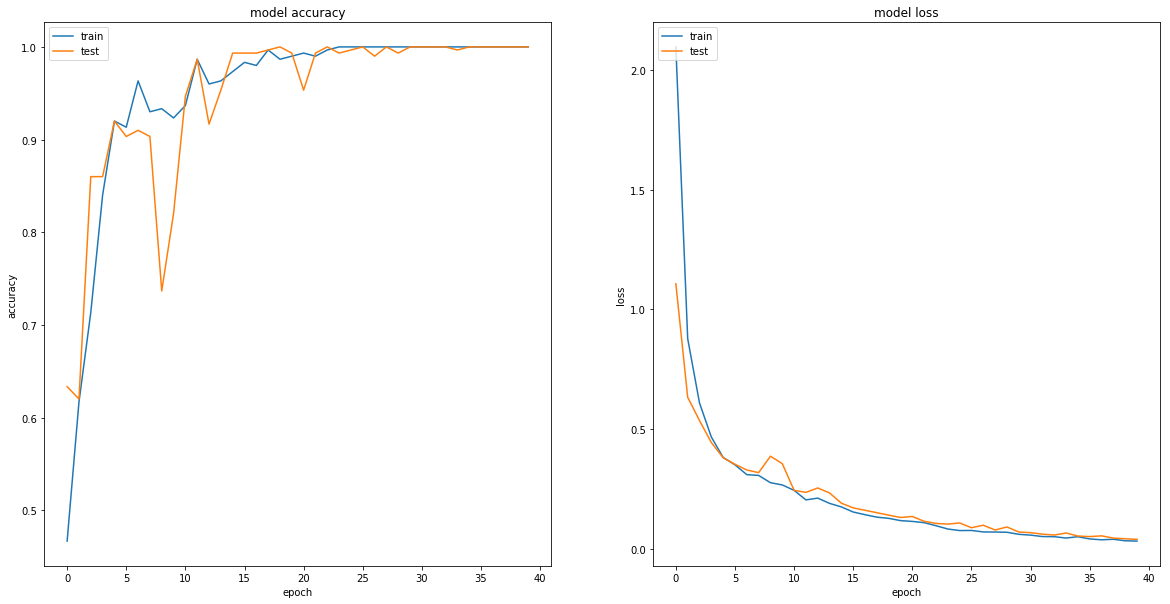

In [104]:
models['adam'] = Sequential()
models['adam'].add(Dense(n_classes, input_shape=(X_train.shape[1],), activation='softmax'))
models['adam'].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
istory = models['adam'].fit(X_train, Y_train, batch_size=32, epochs=40, 
                             validation_data=(X_test, Y_test), verbose=0)
plot_history(history)

# 3. Visualization of the Solution

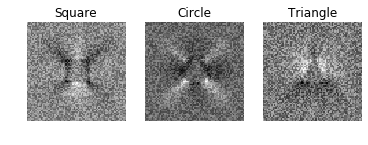

In [108]:
weights = models['adam'].get_weights()[0].reshape(72,72,3)
titles = ["Square", "Circle", "Triangle"]

for k in range(3):
    plt.subplot(1, 3, k + 1)
    plt.imshow(weights[..., k].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title(titles[k])
    plt.axis("off")

plt.show()

# 4. A More Difficult Classification Problem

In [2]:
X_train, Y_train = generate_dataset_classification(600, 20, True)
X_test, Y_test = generate_test_set_classification(300, 20, True)

Creating data: 100%|██████████| 300/300 [00:03<00:00, 96.82it/s] 


300/300 [==============================] - 0s 53us/step
Evaluation on the test set: accuracy 96.00% - loss 0.19


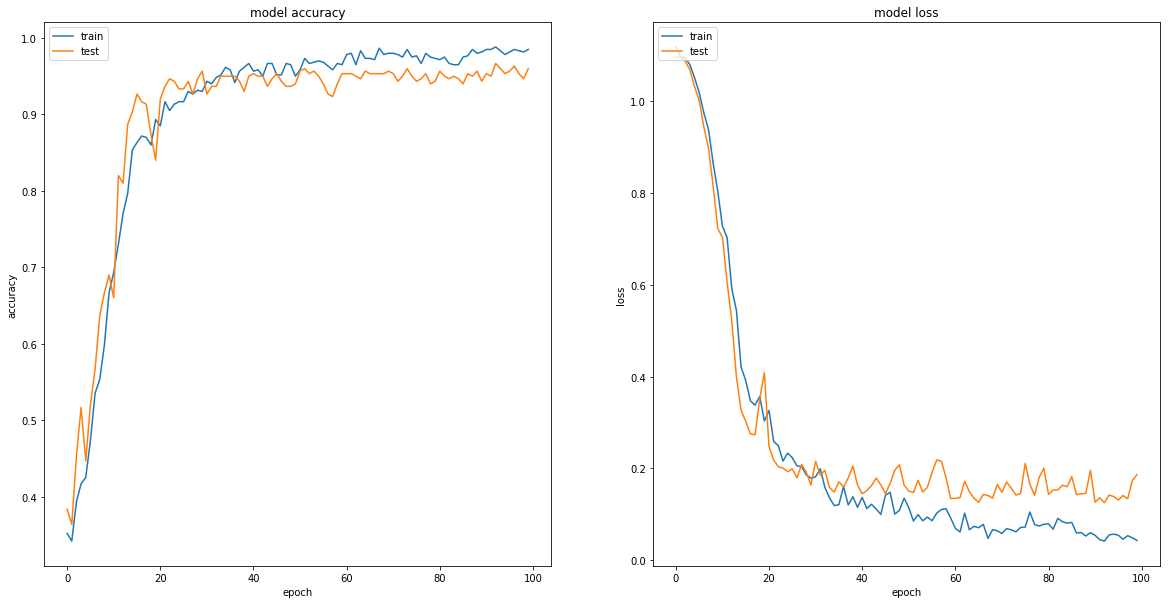

In [21]:
models['convnet'] = Sequential()
models['convnet'].add(Conv2D(32,(5,5), strides=3, activation='relu', input_shape=(72,72,1))) #filters
models['convnet'].add(MaxPooling2D(pool_size=(2,2))) #pooling layer
models['convnet'].add(Dropout(0.5))
models['convnet'].add(Conv2D(16,(5,5), activation='relu')) #filters
models['convnet'].add(MaxPooling2D(pool_size=(2,2))) #pooling layer
models['convnet'].add(Dropout(0.25))
models['convnet'].add(Flatten())
models['convnet'].add(Dense(256))
models['convnet'].add(Activation('relu'))
models['convnet'].add(Dropout(0.5))
models['convnet'].add(Dense(3))
models['convnet'].add(Activation('softmax'))
models['convnet'].compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy'])

X_train2 = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, -1).astype('float32')
X_test2 = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, -1).astype('float32')

history = models['convnet'].fit(X_train2, Y_train, batch_size=32, epochs=100, 
                             validation_data=(X_test2, Y_test), verbose=0)

evaluation = models['convnet'].evaluate(X_test2, Y_test)
print(f"Evaluation on the test set: accuracy {evaluation[1]*100:.2f}% - loss {evaluation[0]:.2f}")

plot_history(history)



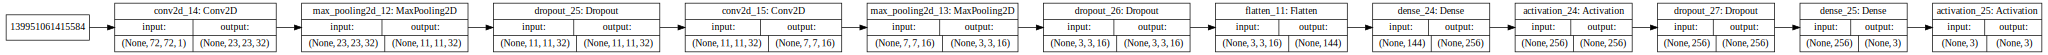

In [22]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model2, show_shapes=True, rankdir="LR").create(prog='dot', format='svg'))

# 5. Regression problem

In [23]:
def preprocessing(data):
    Y = (data[1] - 0.5)/0.5
    n_samples = len(Y)
    middle = 0.5
    for i in range(0, n_samples):
        A = Y[i].reshape((3,2))
        a = A[np.argsort(np.sum(A, axis=1)), :]
        Y[i] = a.ravel()
    X = data[0].reshape(data[0].shape[0], IMAGE_SIZE, IMAGE_SIZE, 1).astype('float32')
    return X, Y



def postprocessing(Y):
    Y = Y * 0.5 + 0.5
    return Y

n_output = 6
X_train, Y_train = preprocessing(generate_dataset_regression(300, 20, True))
X_test, Y_test = preprocessing(generate_test_set_regression(300, 20, True)) 

Creating data: 100%|██████████| 300/300 [00:03<00:00, 96.59it/s] 


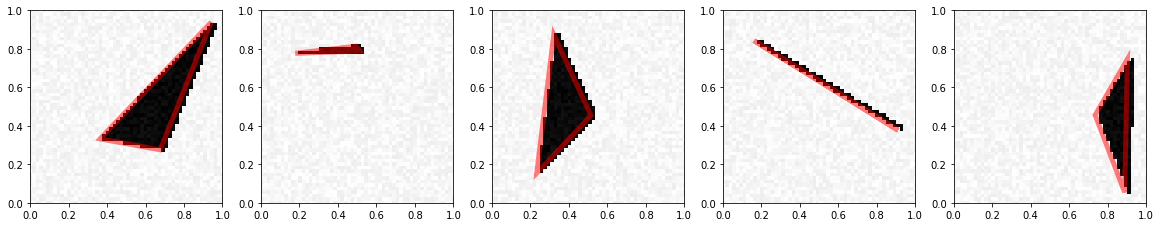

In [24]:
n = 5
visualize_predictions(X_test[:n], postprocessing(Y_test[:n]))

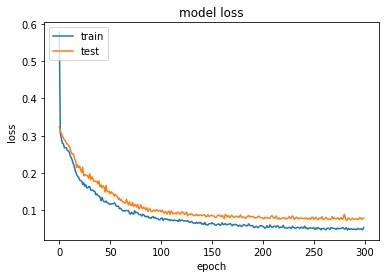

300/300 [==============================] - 0s 93us/step
Evaluation on the test set: MSE 0.08, MAE: 0.22


In [25]:
reg = 0e-4

model3 = Sequential()
model3.add(Conv2D(32, activation='relu', strides=2, input_shape=(72,72,1), kernel_size=(5,5), kernel_regularizer=l2(reg), padding="same"))
model3.add(Dropout(0.5))
model3.add(MaxPooling2D(pool_size=(2,2), padding="same"))
model3.add(Conv2D(32, (5,5), activation="relu", padding="same", kernel_regularizer=l2(reg)))
model3.add(Dropout(0.5))
model3.add(MaxPooling2D(pool_size=(2,2), padding="same"))
model3.add(Flatten())
model3.add(Dense(256, activation='relu', kernel_regularizer=l2(reg)))
model3.add(Dropout(0.5))
model3.add(Dense(256, activation='relu', kernel_regularizer=l2(reg)))
model3.add(Dropout(0.5))
model3.add(Dense(128, activation='relu', kernel_regularizer=l2(reg)))
model3.add(Dropout(0.5))
model3.add(Dense(n_output))


model3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

progress_bar = TQDMNotebookCallback(show_inner=False)
history = model3.fit(X_train, Y_train, batch_size=64, epochs=300, shuffle=True, \
                     validation_data = (X_test, Y_test), verbose=0,  callbacks=[progress_bar])
plot_history(history)
evaluation = model3.evaluate(X_test, Y_test)

print(f"Evaluation on the test set: MSE {evaluation[0]:.2f}, MAE: {evaluation[1]:.2f}")

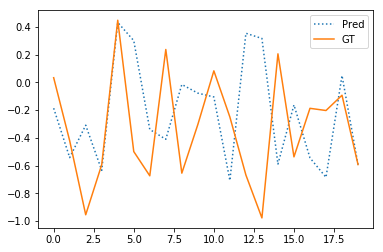

In [27]:
pred = model3.predict(X_test) 
plt.plot(pred[:20,0], label="Pred", linestyle=":")
plt.plot(Y_train[:20,0], label="GT")
plt.legend()

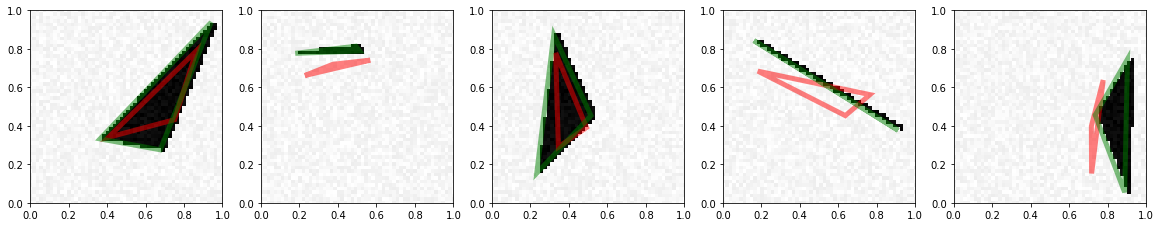

In [28]:
predictions = model3.predict(X_test)
n = 5
visualize_predictions(X_test[:n], postprocessing(predictions[:n]), postprocessing(Y_test[:n]))

# 6. Image Denoising
**Implement a hourglass network for denoising: Modifying the generate_a_* functions to generate
pairs of images, where one image has noise with random amplitude, and the second image has the
same content but without the noise. Train your network to predict a noise-free image given a noisy
image as input.**

I am impletementing a SegNet.

V. Badrinarayanan, A. Kendall, and R. Cipolla, “SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation.”

In [54]:
X_train, Y_train = generate_dataset_noise(300, 20, True)
X_test, Y_test = generate_dataset_noise(300, 20, True)


100%|██████████| 300/300 [00:06<00:00, 45.59it/s]

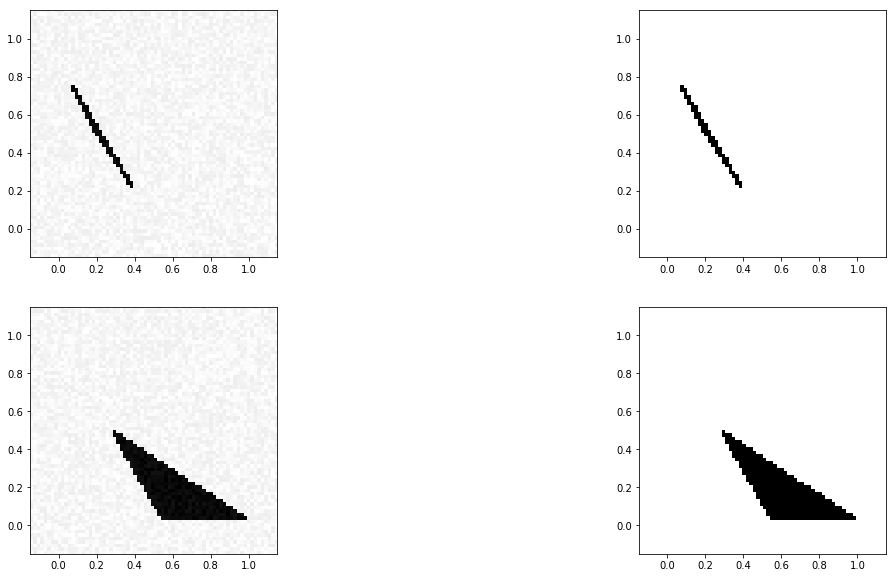

In [55]:
visualize_denoising(X_train[:2], Y_train[:2])

In [41]:
model = Sequential()
model.add(Convolution2D(60, kernel_size=()))

(300, 72, 72, 1)


In [33]:
from mp1 import *
import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Convolution2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import UpSampling2D

############6 Bonus Question#############



#This first part contains the denoising tool dealed as a regression problem
#MSE loss
mcp = ModelCheckpoint('weights.best_hourglass.hdf5', monitor="val_loss",
                      save_best_only=True, save_weights_only=False)


X_train_noise,Y_train_noise = generate_dataset_noise(5000) 
X_test_noise,Y_test_noise = generate_test_set_noise() 


X_train_noise = X_train_noise.reshape((-1,72,72,1))
Y_train_noise = Y_train_noise.reshape((-1,72,72,1))

X_test_noise = X_test_noise.reshape((-1,72,72,1))
Y_test_noise = Y_test_noise.reshape((-1,72,72,1))

model =Sequential()

model.add(Convolution2D(60,kernel_size=(3,3),input_shape=(72,72,1,),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(40,kernel_size=(2,2),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(60,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(40,kernel_size=(2,2),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(60,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(20,kernel_size=(2,2),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(UpSampling2D(size=(2,2)))
model.add(Convolution2D(40,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(20,kernel_size=(2,2),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(UpSampling2D(size=(2,2)))
model.add(keras.layers.convolutional.ZeroPadding2D(padding=(1, 1)))
model.add(Convolution2D(1,kernel_size=(3,3)))

model.compile(loss='mean_squared_error',
              optimizer='adam')

history= model.fit(X_train_noise,Y_train_noise,validation_split=0.1,epochs=50,batch_size=100,callbacks=[mcp])

model = keras.models.load_model('weights.best_hourglass.hdf5')

print('Model outcome regression:',model.evaluate(X_test_noise,Y_test_noise))

Y_pred_without_noise = model.predict(X_test_noise)

#print some results
plt.imshow(Y_train_noise[0].reshape(72,72), cmap='gray')
plt.title('Output train denoising')
plt.savefig('output_train.png', dpi=500)

plt.imshow(X_train_noise[0].reshape(72,72), cmap='gray')
plt.title('Input train denoising')
plt.savefig('input_train.png', dpi=500)

plt.imshow(Y_pred_without_noise[0].reshape(72,72), cmap='gray')
plt.title('Predicted Output test denoising')
plt.savefig('predict_output_test.png', dpi=500)

plt.imshow(X_test_noise[0].reshape(72,72), cmap='gray')
plt.title('Input test denoising')
plt.savefig('input_test.png', dpi=500)

#This second part contains the network that deals with our denoising
#task as a segmentation problem

mcp = ModelCheckpoint('weights.best_hourglass.hdf5', monitor="val_loss",
                      save_best_only=True, save_weights_only=False)


X_train_noise,Y_train_noise = generate_dataset_noise_segmentation(5000) 
X_test_noise,Y_test_noise = generate_test_set_noise_segmentation() 


X_train_noise = X_train_noise.reshape((-1,72,72,1))
Y_train_noise = Y_train_noise.reshape((-1,72,72,1))

X_test_noise = X_test_noise.reshape((-1,72,72,1))
Y_test_noise = Y_test_noise.reshape((-1,72,72,1))

mcp = ModelCheckpoint('weights.best_hourglass_segment.hdf5', monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

model =Sequential()

model.add(Convolution2D(60,kernel_size=(3,3),input_shape=(72,72,1,),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(40,kernel_size=(2,2),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(60,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(40,kernel_size=(2,2),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(60,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(20,kernel_size=(2,2),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(UpSampling2D(size=(2,2)))
model.add(Convolution2D(40,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(20,kernel_size=(2,2),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(UpSampling2D(size=(2,2)))
model.add(keras.layers.convolutional.ZeroPadding2D(padding=(1, 1)))
model.add(Convolution2D(1,kernel_size=(3,3)))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

history= model.fit(X_train_noise,Y_train_noise,validation_split=0.1,epochs=50,batch_size=100,callbacks=[mcp])

model = keras.models.load_model('weights.best_hourglass_segment.hdf5')

print('Model outcome',model.evaluate(X_test_noise,Y_test_noise))

Y_pred_without_noise = model.predict(X_test_noise)

#print outcomes
plt.imshow(Y_train_noise[0].reshape(72,72), cmap='gray')
plt.title('Output train denoising')
plt.savefig('output_train_seg.png', dpi=500)

plt.imshow(X_train_noise[0].reshape(72,72), cmap='gray')
plt.title('Input train denoising')
plt.savefig('input_train_seg.png', dpi=500)

plt.imshow(Y_pred_without_noise[0].reshape(72,72), cmap='gray')
plt.title('Predicted Output test denoising')
plt.savefig('predict_output_test_seg.png', dpi=500)

plt.imshow(X_test_noise[0].reshape(72,72), cmap='gray')
plt.title('Input test denoising')
plt.savefig('input_test_seg.png', dpi=500)

ModuleNotFoundError: No module named 'sklearn'